In [1]:
import torch
import torch.nn.functional as F
import numpy as np

In [2]:
if torch.backends.mps.is_available():
    print("Metal backend available, will use it")
    device = "mps"
    %env PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0
elif torch.cuda.is_available():
    print(f"CUDA available, device: {torch.cuda.get_device_name(0)}")
    device = "cuda"
else:
    print("Will use CPU")
    device = "cpu"

torch.set_default_device(device)

CUDA available, device: NVIDIA GeForce RTX 4080 SUPER


# I LOVE CNNs
The goal of this project is to build a simple CNN classifier using only torch's tensors and other few helpers

## Prepare Dataset

In [ ]:
!curl -L -o car-brand-classification-dataset.zip\
    https://www.kaggle.com/api/v1/datasets/download/ahmedelsany/car-brand-classification-dataset
!unzip car-brand-classification-dataset.zip

In [3]:
import os

DATASET_PATH = 'Car Brand Classification Dataset'

path = os.path.join(DATASET_PATH, 'train')
classes = [classname for classname in os.listdir(path)]
print(f"There are {len(classes)} classes, the first three: {classes[:3]}")

There are 33 classes, the first three: ['Acura', 'Aston Martin', 'Audi']


In [4]:
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor


class LazyImage:
    IMG_SIZE = (320, 240)
    
    def __init__(self, path: str):
        self.path = path
        
    def load(self):
        image = Image.open(self.path)
        # For some reason some images have a slightly smaller size...
        image = pil_to_tensor(image.resize(self.IMG_SIZE))
        # Normalize pixels [0, 1] absolutely
        return image / 255.0
        

def build_dataset(split: str) -> torch.Tensor:
    X, Y = [], []
    
    split_path = os.path.join(DATASET_PATH, split)
    for cls in classes:
        path = os.path.join(split_path, cls)
        for image_name in os.listdir(path):
            if 'jpg' not in image_name:
                continue
            X.append(LazyImage(os.path.join(path, image_name)))
            Y.append(classes.index(cls))
            
    perm = torch.randperm(len(X))
    X, Y = [X[i] for i in perm], torch.tensor(Y)[perm]
    return X, Y


Xtrain, Ytrain = build_dataset('train')
Xdev, Ydev = build_dataset('val')
Xtest, Ytest = build_dataset('test')

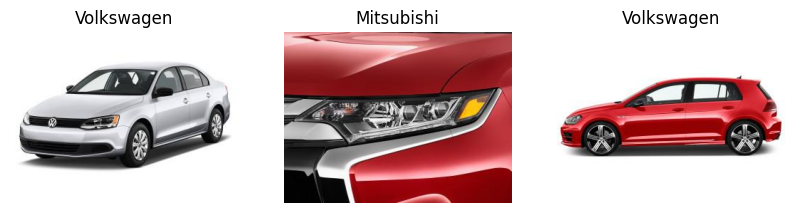

In [5]:
import matplotlib.pyplot as plt

# Show first few images of training set
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for ax, img, class_index in zip(axes, Xtrain[:3], Ytrain[:3]):
    # Unnomralize pixels
    img = img.load()
    img = img * 255
    # Permute from (C, H, W) convention to (H, W, C)
    img = img.permute(1, 2, 0)
    # Normalize to [0,1] for display realatively to image
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(torch.Tensor.cpu(img))
    ax.axis('off')
    ax.set_title(classes[class_index])
    # ax.set_aspect(img.shape[0]/img.shape[1])
plt.show()

In [6]:
# Kernels should be (C_out, C_in, kH, kW)
# Inout shape (3, H, W)
# output_size = (W + 2*padding - kernel_size) / stride + 1
# We'll limit the kernel shape to a squre for simplicity

# randn generates tensors woth standard deviation = to 1, 
# after many layer activations with these numbers might explode, 
# beacuse od this we use this index to initialize values wiht smaller variance


class Conv2d:
    num_params = 0
    params = []
    CUSTOM_IMG2COL = False
    GLOBAL_SCALING = 0.05 # Deprecated
    CUSTOM_PADDING = True
    
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1, padding: int = 1, bias: bool = True):
        self.kernels = torch.randn(out_channels, in_channels, kernel_size, kernel_size) # * Conv2d.GLOBAL_SCALING
        # Add a single scalar which will be added to the respective out_channel
        self.bias = torch.zeros(out_channels) # * Conv2d.GLOBAL_SCALING
        self.kernels.requires_grad = True
        self.bias.requires_grad = bias
        self.stride = stride
        self.padding = padding
        Conv2d.params.append(self.kernels)
        if bias:
            Conv2d.params.append(self.bias)
        Conv2d.num_params += in_channels * out_channels * kernel_size**2 + out_channels
        print(f"Built layer with kernel shape ({self.kernels.shape}), {'with' if bias else 'no'} bias and stride {stride}")

    @property
    def kernel_size(self) -> int:
        return self.kernels.shape[2]
    
    @property
    def out_channels(self) -> int:
        return self.kernels.shape[0]
    
    @classmethod
    def reset(cls):
        cls.params.clear()
        cls.num_params = 0

    @staticmethod
    def img2col(x: torch.Tensor, kernel_size: int, stride: int) -> torch.Tensor:
        """Implementing the img2col method by extracing each input patch and flattening it into a single vector.
        Args:
            - x: Is the actual batch of images
            - kernel_size: The size of the kernel, W and H correspond
            - stride: The stride of the sliding window

        Returns:
            The flattened patches of the images of shape (B, <patch_num>, C_in * kH * kW), 
            where patch_num = ((H - kernel_size) // stride + 1) * ((W - kernel_size) // stride + 1)

        """
        B, C, H, W = x.shape
        H_out = (H - kernel_size) // stride + 1
        W_out = (W - kernel_size) // stride + 1
        patches = []

        if Conv2d.CUSTOM_IMG2COL:
            for i in range(0, H - kernel_size + 1, stride):
                for j in range(0, W - kernel_size + 1, stride):
                    patch = x[:, :, i:kernel_size+i, j:kernel_size+j]
                    patches.append(torch.flatten(patch, start_dim=1))
            # Stack along second dim since the first is still the Batch
            return torch.stack(patches, dim=1), H_out, W_out
        else:
            patches = F.unfold(x, kernel_size=kernel_size, stride=stride)
            return patches.permute(0, 2, 1), H_out, W_out

    @staticmethod
    def pad(x: torch.Tensor, padding: int) -> torch.Tensor:
        if Conv2d.CUSTOM_PADDING:
            B, C, H, W = x.shape
            padded_H, padded_W = H + 2 * padding, W + 2 * padding
            padded = torch.zeros(B, C, padded_H, padded_W)
            padded[:, :, padding:padded_H-padding, padding:padded_W-padding] = x
            return padded
        else:
            return F.pad(x, (padding, padding, padding, padding))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Does the forward pass given an input, using the parameters defined when the layer is initialized.
        Args:
            - x: The input batch tensor
            
        Returns:
            The output features
        """
        B, C, H, W = x.shape
        x = self.pad(x, self.padding)
        
        # all of this could be avoided using F.unfold, doing this for the sake of learning
        # We'll need to flatten our kernel into a single dimension of size C_in * kH * kW for each channel
        W = torch.flatten(self.kernels, start_dim=1) # (C_out, 27)
        flattened_patches, H_out, W_out = self.img2col(x, self.kernel_size, self.stride) # (<patch_num>, 27)
        
        # Calculate the features with a single matrix multiplication leveraging torch broadcasting
        # Need to transpose the patches matrix, result -> (C_out, <patch_num>)
        out = (flattened_patches @ W.T).transpose(1, 2) + self.bias.view(1, -1, 1)
        return out.view(B, self.out_channels, H_out, W_out)

    __call__ = forward


class Dense:
    num_params = 0
    params = []
    
    def __init__(self, in_features: int, out_features: int):
        self.W = torch.randn(in_features, out_features)
        self.b = torch.zeros(out_features)
        self.W.requires_grad = True
        self.b.requires_grad = True
        
        Dense.params.append(self.W)
        Dense.params.append(self.b)
        Dense.num_params += in_features * out_features + out_features
        print(f"Built Linear layer of shape ({self.W.shape}) + {self.b.shape}")
        
    @classmethod
    def reset(cls):
        cls.params.clear()
        cls.num_params = 0

    def forward(self, x: torch.Tensor):
        return x @ self.W + self.b # batches handled automatically by torch broadcasting

    __call__ = forward


In [42]:
# Test forward pass
l = Conv2d(3, 10, 3)
image = Xtrain[0].load()
l.forward(image.unsqueeze(0))

Built layer with kernel shape (torch.Size([10, 3, 3, 3])), with bias and stride 1


tensor([[[[ 7.5835,  7.3096,  7.3096,  ...,  7.3096,  7.3096,  6.2387],
          [ 4.8892,  7.5440,  7.5440,  ...,  7.5440,  7.5440,  8.4298],
          [ 4.8892,  7.5440,  7.5440,  ...,  7.5440,  7.5440,  8.4298],
          ...,
          [ 4.8892,  7.5440,  7.5440,  ...,  7.5120,  7.5105,  8.3404],
          [ 4.8892,  7.5440,  7.5440,  ...,  7.5104,  7.5304,  8.2980],
          [ 2.7188,  4.0702,  4.0702,  ...,  4.0428,  4.0938,  5.3691]],

         [[ 1.0816,  1.0101,  1.0101,  ...,  1.0101,  1.0101,  0.8308],
          [ 2.4228,  1.4286,  1.4286,  ...,  1.4286,  1.4286,  0.7931],
          [ 2.4228,  1.4286,  1.4286,  ...,  1.4286,  1.4286,  0.7931],
          ...,
          [ 2.4228,  1.4286,  1.4286,  ...,  1.4312,  1.4400,  0.7730],
          [ 2.4228,  1.4286,  1.4286,  ...,  1.4405,  1.4296,  0.7555],
          [ 2.0136,  1.0665,  1.0665,  ...,  1.0813,  1.0309, -0.3731]],

         [[-2.6080,  3.4189,  3.4189,  ...,  3.4189,  3.4189,  2.0560],
          [-5.6585,  0.1067,  

In [43]:
# Test padding
l.pad(torch.arange(3*5*5).reshape(3, 5, 5).unsqueeze(0), 1)

tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  1.,  2.,  3.,  4.,  0.],
          [ 0.,  5.,  6.,  7.,  8.,  9.,  0.],
          [ 0., 10., 11., 12., 13., 14.,  0.],
          [ 0., 15., 16., 17., 18., 19.,  0.],
          [ 0., 20., 21., 22., 23., 24.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]],

         [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0., 25., 26., 27., 28., 29.,  0.],
          [ 0., 30., 31., 32., 33., 34.,  0.],
          [ 0., 35., 36., 37., 38., 39.,  0.],
          [ 0., 40., 41., 42., 43., 44.,  0.],
          [ 0., 45., 46., 47., 48., 49.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]],

         [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0., 50., 51., 52., 53., 54.,  0.],
          [ 0., 55., 56., 57., 58., 59.,  0.],
          [ 0., 60., 61., 62., 63., 64.,  0.],
          [ 0., 65., 66., 67., 68., 69.,  0.],
          [ 0., 70., 71., 72., 73., 74.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]]], device

## Actual Net Architecture
Input: 320x240x3
--------------------------------
Conv2d(3 -> 32, kernel=3, stride=1, padding=1)  
ReLU  
MaxPool2d(2x2)  # down to 160x120

Conv2d(32 -> 64, kernel=3, stride=1, padding=1)  
ReLU  
MaxPool2d(2x2)  # down to 80x60

Conv2d(64 -> 128, kernel=3, stride=1, padding=1)  
ReLU  
MaxPool2d(2x2)  # down to 40x30

Conv2d(128 -> 256, kernel=3, stride=1, padding=1)  
ReLU  
MaxPool2d(2x2)  # down to 20x15

Flatten  
Linear(256*20*15 -> 512)  
ReLU  
Dropout(0.5)  
Linear(512 -> 33)  # output layer
Softmax (if you want probabilities)

In [7]:
# Implementation of dropout because why not
class Dropout:
    def __init__(self, prob: float):
        self.p = prob
        self.mask = None
        self.training = True

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.training:
            return x
        # Generate mask
        self.mask = (torch.rand_like(x) > self.p).float()
        # mask, then normalize not killed neurons to keep the mean activation
        return x * self.mask / (1.0 - self.p)

    __call__ = forward
    

class Maxpool:
    def __init__(self, window_size: int):
        self.window_size = window_size
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        patches, H_out, W_out = Conv2d.img2col(x, self.window_size, self.window_size)
        patches = patches.view(B, -1, C, self.window_size**2) # -1 is the patch_num
        values, indeces = patches.max(dim=3)
        return values.view(B, C, H_out, W_out)
    
    __call__ = forward


class GlobalAvgPool2d:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, channels, H, W)
        return x.mean(dim=(2,3), keepdim=True) # (batch, channels, 1, 1)
    

class BatchNorm:
    params = []
    num_params = 0
    momentum = 0.001
    
    def __init__(self, fan_in):
        # Add trainable gain and bias to the actual normalization
        self.gain = torch.ones(1, fan_in, requires_grad=True)
        self.bias = torch.zeros(1, fan_in, requires_grad=True)
        self.epsilon = 1e-5 # constant to avoid division by 0
        BatchNorm.params.append(self.gain)
        BatchNorm.params.append(self.bias)
        BatchNorm.num_params += fan_in * 2
        self.training = True
        # The running mean is calculated during training to avoid calculating all the times dynamically at each inference.
        self.running_mean = torch.zeros(1, fan_in)
        self.running_std = torch.ones(1, fan_in)
        
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        mean = x.mean(dim=0, keepdim=True)
        variance = x.var(dim=0, keepdim=True)
        std = torch.sqrt(variance + self.epsilon)
               
        if self.training:
            with torch.no_grad():
                # Mostly what it used to be but receiving a small update in the direction of the new mean
                                    # 0.999                              # 0.001
                self.running_mean = (1 - BatchNorm.momentum) * self.running_mean + BatchNorm.momentum * mean
                self.running_std = (1 - BatchNorm.momentum) * self.running_std + BatchNorm.momentum * std
        else:
            # Will use this when not training (equivalent to doing the mean across all data in batch (almost))
            mean = self.running_mean
            std = self.running_std
               
        return self.gain * (x - mean) / std + self.bias
    
    def reset():
        BatchNorm.num_params = 0
        BatchNorm.params.clear()


class BatchNorm2d:
    params = []
    num_params = 0
    momentum = 0.001
    
    def __init__(self, in_channels):
        # Each channel will have a bias that will be broadcaste across batches and input dimensions
        self.gain = torch.ones(1, in_channels, 1, 1, requires_grad=True)
        self.bias = torch.zeros(1, in_channels, 1, 1, requires_grad=True)
        self.epsilon = 1e-5
        BatchNorm2d.params.append(self.gain)
        BatchNorm2d.params.append(self.bias)
        BatchNorm2d.num_params += in_channels * 2
        self.training = True
        self.running_mean = torch.zeros(1, in_channels, 1, 1)
        self.running_std = torch.ones(1, in_channels, 1, 1)
        
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        mean = x.mean(dim=(0, 2, 3), keepdim=True)
        variance = x.var(dim=(0, 2, 3), keepdim=True)
        std = torch.sqrt(variance + self.epsilon)
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - BatchNorm2d.momentum) * self.running_mean + BatchNorm2d.momentum * mean
                self.running_std = (1 - BatchNorm2d.momentum) * self.running_std + BatchNorm2d.momentum * std
        else:
            mean = self.running_mean
            std = self.running_std
        
        return self.gain * (x - mean) / std + self.bias
    
    def reset():
        BatchNorm2d.num_params = 0
        BatchNorm2d.params.clear()


In [30]:
from torch.nn import Softmax, ReLU
from torch.nn.modules.flatten import Flatten

Conv2d.reset(); Dense.reset(); BatchNorm.reset(); BatchNorm2d.reset()
NET = [
    Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False), # Remove bias since it would be zeroed out when subtracting the mean in batch-norm
    BatchNorm2d(32),
    ReLU(),
    Maxpool(2), # down to 160x120
    Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
    BatchNorm2d(64),
    ReLU(),
    Maxpool(2), # down to 80x60
    Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
    BatchNorm2d(128),
    ReLU(),
    Maxpool(2), # down to 40x30 
    Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
    BatchNorm2d(256),
    ReLU(),
    Maxpool(2), # down to 20x15
    # GlobalAvgPool2d(),
    Flatten(start_dim=1),
    Dense(256*20*15, 512),
    # Dense(256, 512),
    BatchNorm(512),
    ReLU(),
    Dropout(0.5),
    Dense(512, 33), # Output classes
    # Softmax(dim=1)
]
print(f"Number of conv2d params: {Conv2d.num_params}")
print(f"Number of Linear params: {Dense.num_params}")
print(f"Total number of params: {(Conv2d.num_params + Dense.num_params + BatchNorm.num_params + BatchNorm2d.num_params) / 1_000_000:.1f}M")

# I'll do this because scaling just kills the gradient
for p in Conv2d.params + Dense.params:
    if len(p.shape) > 1:
        # This makes all outputs preserve the original std
        torch.nn.init.kaiming_normal_(p, nonlinearity='relu') # Equivalent of scaling weights * (2/fan_in)**0.5 [relu has gain 2]
    else:
        p.data *= 0
        
NET[-1].W.data *= 0.1

Built layer with kernel shape (torch.Size([32, 3, 3, 3])), no bias and stride 1
Built layer with kernel shape (torch.Size([64, 32, 3, 3])), no bias and stride 1
Built layer with kernel shape (torch.Size([128, 64, 3, 3])), no bias and stride 1
Built layer with kernel shape (torch.Size([256, 128, 3, 3])), no bias and stride 1
Built Linear layer of shape (torch.Size([76800, 512])) + torch.Size([512])
Built Linear layer of shape (torch.Size([512, 33])) + torch.Size([33])
Number of conv2d params: 388416
Number of Linear params: 39339041
Total number of params: 39.7M


## Forward pass

In [9]:
def forward(batch: torch.Tensor, training: bool = True, verbose: bool = False):
    logits = batch
    for layer in NET:
        if isinstance(layer, (Dropout, BatchNorm, BatchNorm2d)):
            layer.training = training
        logits = layer(logits)
        # Save for later
        layer.out = logits
        if verbose:
            print(f" Output shape of {layer.__class__.__name__:<15} -> {str(logits.shape):<15} ".center(80, "-"))
            print(f" fraction of neurons firing: {(logits > 0).float().mean().item()} ".center(80, "-"))
            print(f" logits mean: {logits.detach().mean()}, logits std {logits.detach().std()} ".center(80, "-"))
            print("-" * 80)
        
    return logits, F.softmax(logits, dim=1)

def gradient_clipping(p: torch.Tensor, total_norm: float, max_norm: float = 1):
    """Applies gradient norm clipping in place when the norm exceedes the max_norm parameter."""
    clip_coef_ratio = max_norm / (total_norm + 1e-6)
    if clip_coef_ratio < 1:
        p.grad.data *= clip_coef_ratio

def backward(logits: torch.Tensor, Y: torch.Tensor, lr: float, max_norm: float = 1, debug: bool = False):
    loss = F.cross_entropy(logits, Y)
    params = Conv2d.params + Dense.params + BatchNorm.params + BatchNorm2d.params
    
    if debug:
        for layer in NET:
            # Keep gradients for hidden states for debug pusposes
            layer.out.retain_grad()
    for p in params:
        p.grad = None
    loss.backward()
    
    total_norm = sum((p.grad.data.norm(2).item()**2) for p in params)**0.5
    for p in params:
        gradient_clipping(p, total_norm, max_norm)
    
    for p in params:
        p.data += -lr * p.grad
        
    return loss, total_norm

In [47]:
# Checking if my net is dead 💀
logits, _ = forward(torch.stack([img.load() for img in Xtrain[:2]]), training=False)
print(logits.mean().item(), logits.std().item(), logits)

-0.32586076855659485 14.843740463256836 tensor([[ 9.4070e+00, -1.7035e+01,  6.7893e+00,  1.9650e+01, -6.7334e+00,
          1.4513e+01, -2.1590e+01,  5.8585e+00, -5.3576e+00, -7.9051e+00,
         -3.1080e+00,  2.8688e-02, -1.4253e+01,  7.2628e+00, -1.2529e+01,
         -1.3698e+01,  9.5366e-01, -1.1425e+00, -2.8964e+00,  9.2807e+00,
          1.6794e+01,  2.0630e+01, -2.7900e+01, -2.1555e+01,  2.1975e+01,
          1.4582e+01,  6.8384e-01,  2.3051e+00, -3.2320e+00,  1.8967e+01,
         -6.7594e+00, -1.1426e+01,  4.9271e+00],
        [ 9.1822e+00, -2.5504e+01,  6.3817e+00,  2.9454e+01, -9.1700e+00,
          2.2184e+01, -3.1974e+01,  8.2539e+00, -4.7196e+00, -5.2788e+00,
          3.1279e+00,  3.9656e+00, -1.4896e+01,  1.0837e+01, -1.3817e+01,
         -2.0978e+01,  4.4427e+00,  4.5059e-01, -9.4038e+00,  8.2330e+00,
          2.3316e+01,  1.7921e+01, -3.1153e+01, -2.3797e+01,  2.7066e+01,
          1.5704e+01,  2.2512e+00, -9.5322e-01, -1.5692e+01,  1.6133e+01,
         -9.8939e+00, -

In [ ]:
k = Conv2d.params[0] # First kernels
fig, axes = plt.subplots(32, 3, figsize=(10, 130))
for i in range(k.shape[0]):
    for j, in_c in enumerate(k[i]):
        axes[i, j].imshow(torch.tensor(in_c > 0).cpu(), vmin=0, vmax=1)
plt.show()


## Training

In [10]:
from IPython.display import clear_output

def plot_model(lossi, grad_norms, start_loss, final_loss):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
    axes[0].plot(lossi, label='Loss', color='blue')
    axes[0].set_title('Loss')
    axes[1].plot(grad_norms, label='Gradient Norm', color='red')
    axes[1].set_title('Gradient Norm')
    axes[2].plot([start_loss, final_loss], label='Start and final loss', color='purple')
    axes[2].set_title('Start and final loss')
    axes[2].set_ylim(10**min(lossi), 10**max(lossi))
    plt.xlabel('Iteration / Batch')
    plt.ylabel('Value')
    # plt.title('Loss and Gradient Norm During Training')
    plt.legend()
    plt.show()

In [82]:
LEARNING_RATE = 0.005
BATCH_SIZE = 32
EPOCHS = 40
MAX_NORM = 12
# mini_epoch_train_lossi = []
# mini_epoch_val_lossi = []

In [83]:
lossi = []
grad_norms = []
batches_num = len(Xtrain) // BATCH_SIZE
learning_rates = 10**torch.linspace(-3, 0, batches_num)
mini_epoch_iterations = 100

start_loss = final_loss = None
iterations = 0
for epoch in range(EPOCHS):
    perm = torch.randperm(Ytrain.shape[0])
    # Shuffle training set for each epoch
    Xtrain, Ytrain = [Xtrain[i] for i in perm], Ytrain[perm]
    for i in range(batches_num):
        start_index = BATCH_SIZE * i
        X, Y = Xtrain[start_index:start_index+BATCH_SIZE], Ytrain[start_index:start_index+BATCH_SIZE]
        X = torch.stack([img.load() for img in X])
        
        logits, probs = forward(X, training=True, verbose=False)
        loss, norm = backward(logits, Y, LEARNING_RATE, MAX_NORM, debug=True)
        grad_norms.append(norm)

        clear_output(wait=True)
        print(f"EPOCH {epoch} ----- BATCH {i+1:<5}/{batches_num} ({(i+1)/batches_num:.2%}) ----- Loss is {loss:2f}")
        
        lossi.append(loss.log10().item())
        if start_loss is None:
            start_loss = loss.item()
        else:
            final_loss = loss.item()

        iterations += 1
        if iterations % mini_epoch_iterations == 0:
            train_loss = lossi[-50:]
            val_loss, *_ = split_loss('val', 32, plot=False)
            mini_epoch_train_lossi.append(torch.tensor(train_loss).mean().item())
            mini_epoch_val_lossi.append(torch.tensor(val_loss).mean().item())

plot_model(lossi, grad_norms, start_loss, final_loss)

plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(mini_epoch_train_lossi)
plt.plot(mini_epoch_val_lossi)
plt.legend(['train', 'val'])
plt.show()

EPOCH 10 ----- BATCH 286  /359 (79.67%) ----- Loss is 0.351206


KeyboardInterrupt: 

In [84]:
torch.tensor(mini_epoch_val_lossi).exp()

tensor([2.8784, 2.4994, 2.2352, 1.9075, 1.8959, 1.8180, 1.7614, 1.7426, 1.7332,
        1.7224, 1.7187, 1.7149, 1.7126, 1.7099, 1.7062, 1.7065, 1.7032, 1.6991,
        1.6965, 1.6948, 1.6921, 1.6885, 1.6837, 1.6862, 1.6806, 1.6749, 1.6741,
        1.6724, 1.6686, 1.6658, 1.6633, 1.6637, 1.6585, 1.6524, 1.6526, 1.6509,
        1.6446, 1.6412, 1.6425, 1.6374, 1.6325, 1.6373, 1.6336, 1.6316, 1.6257,
        1.6238, 1.6213, 1.6208, 1.6182, 1.6140, 1.6117, 1.6131, 1.6100, 1.6088,
        1.6040, 1.6020, 1.6012, 1.6011, 1.5979, 1.5967, 1.5964, 1.5937, 1.5918,
        1.5876, 1.5872, 1.5847, 1.5830, 1.5858, 1.5835, 1.5821, 1.5815, 1.5798,
        1.5787, 1.5734, 1.5743, 1.5732, 1.5737, 1.5712, 1.5655, 1.5649, 1.5628,
        1.5602, 1.5617, 1.5606, 1.5595, 1.5590, 1.5589, 1.5585, 1.5584, 1.5579,
        1.5577, 1.5569, 1.5574, 1.5573, 1.5572, 1.5579, 1.5571, 1.5583, 1.5560,
        1.5565, 1.5569, 1.5579, 1.5564, 1.5564, 1.5571, 1.5607, 1.5608, 1.5596,
        1.5611, 1.5650, 1.5606, 1.5647, 

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(NET):
    if isinstance(layer, ReLU):
        hy, hx = torch.histogram(layer.out, range=(0., 3.), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        print(f"Layer {i:<10}, mean {layer.out.mean():+f}, std {layer.out.std():e}, dead neurons {(layer.out == 0).float().mean().item():.2%}")
        legends.append(f"Layer {i} {layer.__class__.__name__}, {layer.out.shape}")
plt.xlim(0, .1)
plt.legend(legends)
plt.title("Activation distribution")

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(NET[12:-3]):
    if isinstance(layer, ReLU):
        hy, hx = torch.histogram(layer.out.grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        print(f"Layer {i:<10}, mean {layer.out.grad.mean():+f}, std {layer.out.grad.std():e}")
        legends.append(f"Layer {i} {layer.__class__.__name__}, {layer.out.shape}")
plt.legend(legends)
plt.xlim(-0.002, 0.002)
plt.title("Gradient distribution")

## Validation

In [ ]:
print([p.data.abs().mean().item() for p in Conv2d.params])
print([p.data.abs().mean().item() for p in Dense.params])
print([p.grad.abs().mean().item() for p in Conv2d.params])
print([p.grad.abs().mean().item() for p in Dense.params])
print(Conv2d.params)

In [ ]:
# Widest prob distribution logprob
torch.tensor(1/33).log()

BATCH 77   /77 (100.00%) ----- Loss is 2.524096
--------------------------------------------- METRICS ----------------------------------------------
Accuracy: 29.82%
Precision: 32.35%
----------------------------------------------------------------------------------------------------


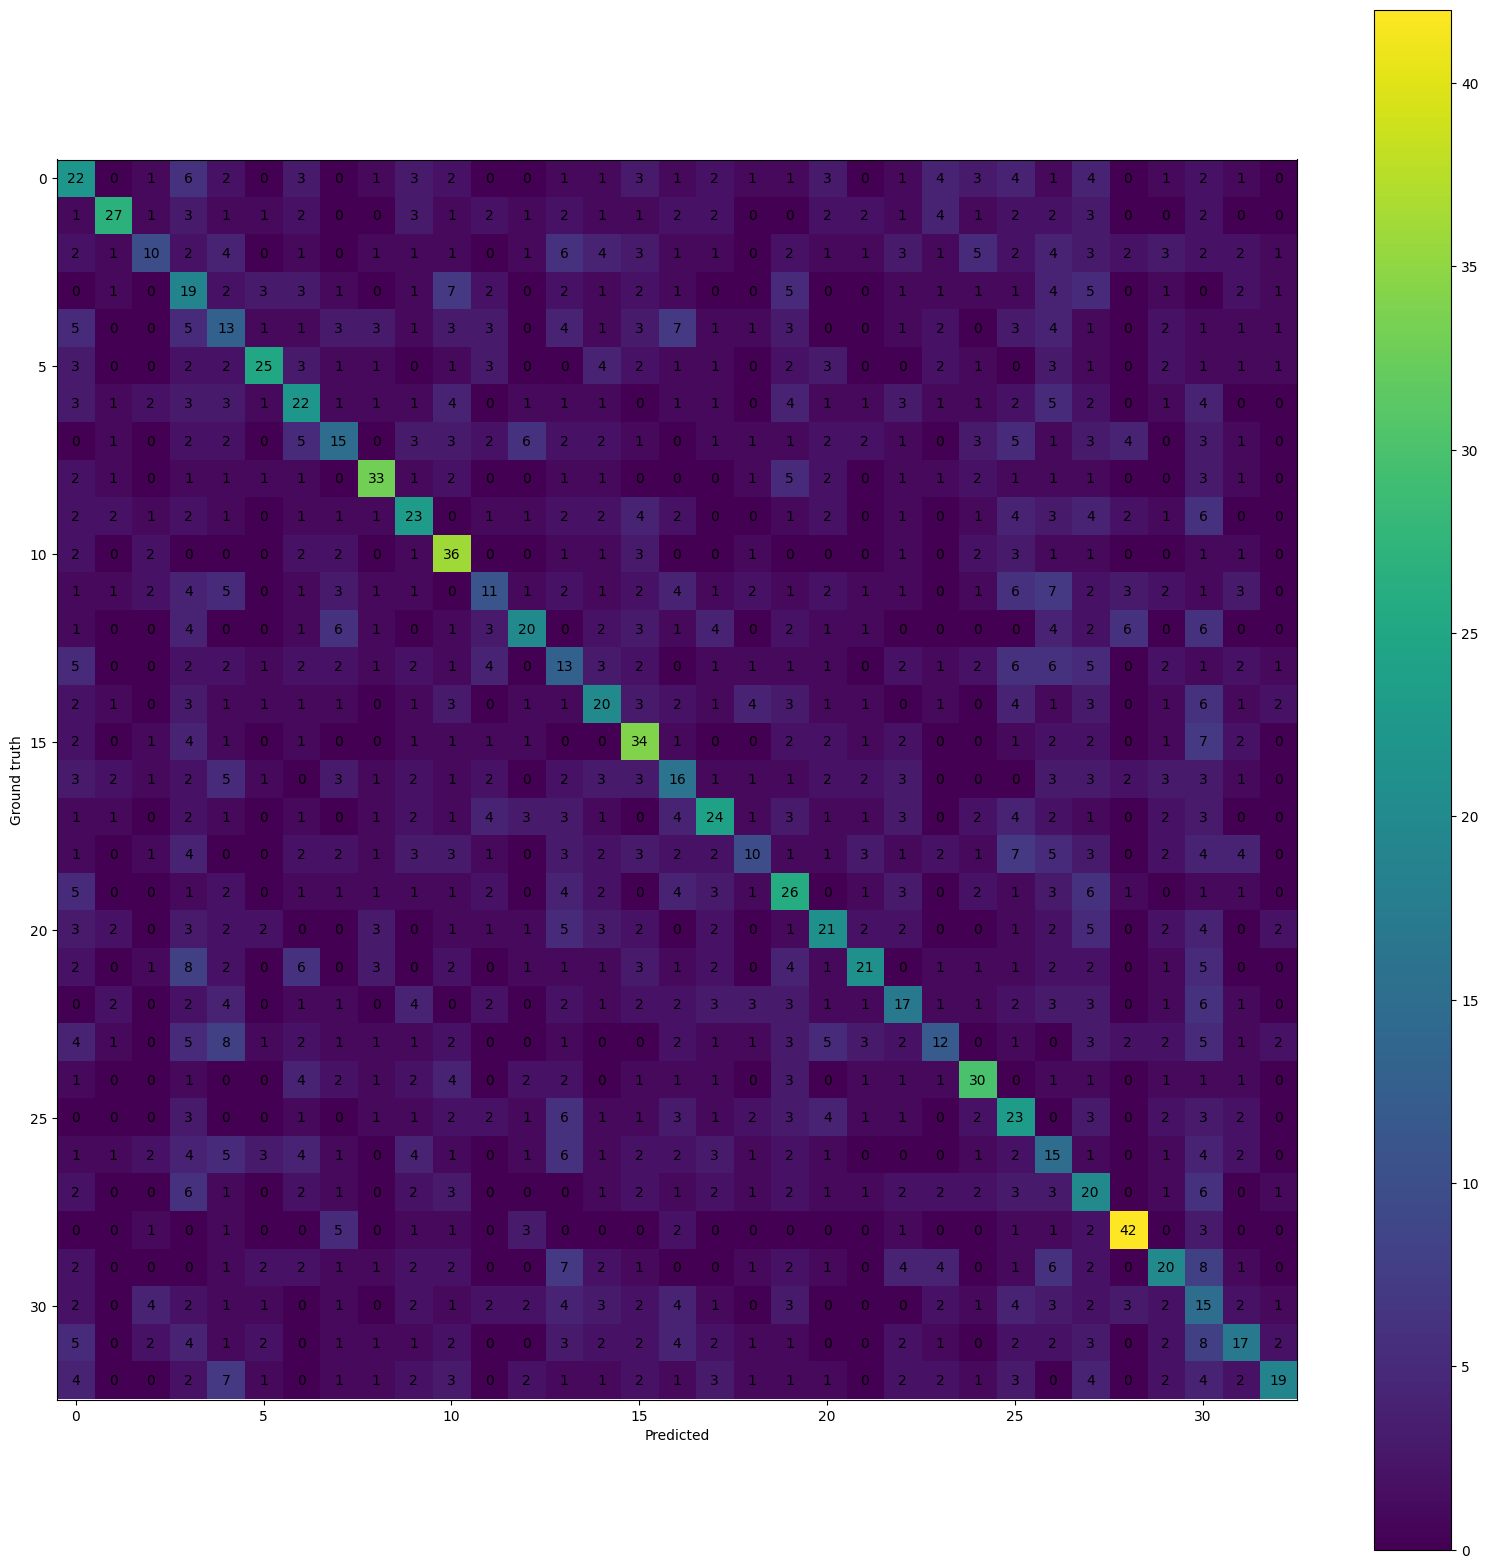

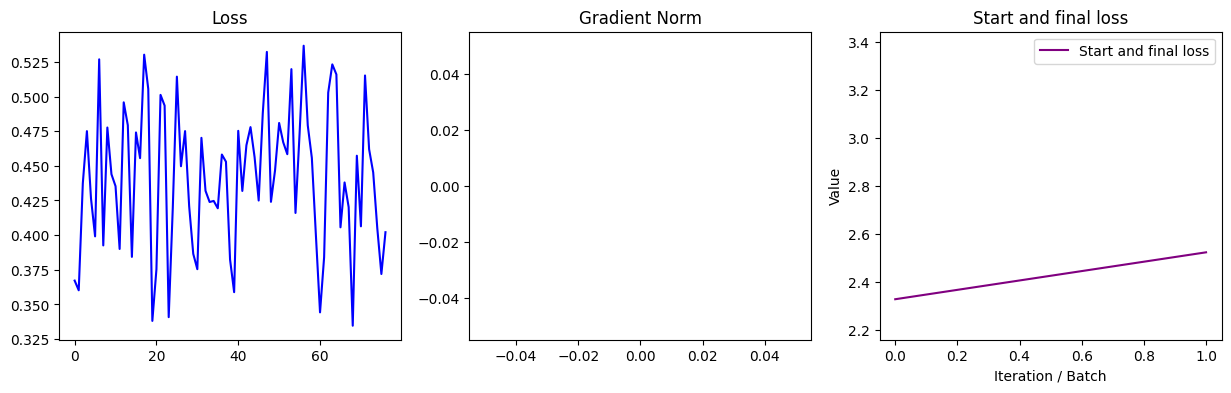

In [85]:
import numpy as np

@torch.no_grad()
def split_loss(split: str, batch_size: int, plot=True):
    lossi = []
    grad_norms = []
    start_loss = final_loss = None
    confusion_matrix = np.zeros((len(classes), len(classes)), int)
    
    Xsplit, Ysplit = {'train': (Xtrain, Ytrain), 'val': (Xdev, Ydev), 'test': (Xtest, Ytest)}[split]
    batches_num = len(Xsplit) // BATCH_SIZE
    
    for i in range(batches_num):
        start_index = BATCH_SIZE * i
        X, Y = Xsplit[start_index:start_index+BATCH_SIZE], Ysplit[start_index:start_index+BATCH_SIZE]
        X = torch.stack([img.load() for img in X])
        
        logits, probs = forward(X, training=False)
        loss = F.cross_entropy(logits, Y)

        clear_output(wait=True)
        print(f"BATCH {i+1:<5}/{batches_num} ({(i+1)/batches_num:.2%}) ----- Loss is {loss:2f}")

        # print(i, [classes[a] for a in Y], [classes[a] for a in probs.argmax(dim=1)])
        # break

        # if (Y != probs.argmax(dim=1)).any():
        #     break

        confusion_matrix[Y.cpu(), probs.argmax(dim=1).cpu()] += 1 # # [GT, predictions of batch]
        lossi.append(loss.log10().item())
        if start_loss is None:
            start_loss = loss.item()
        else:
            final_loss = loss.item()

    accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()
    # lowkey funny since i intended this as precision at index 'i', but also in italian it's the plural of precision :)
    precisioni = np.diag(confusion_matrix) / confusion_matrix.sum(axis=0) # all correct predictions / sum of each row

    if plot:
        print(" METRICS ".center(100, "-"))
        print(f"Accuracy: {accuracy:.2%}")
        print(f"Precision: {precisioni.mean():.2%}")
        print("-" * 100)
    
        plt.figure(figsize=(20, 20))
        plt.imshow(confusion_matrix)
        plt.colorbar()
        # Add text annotations|
        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color='black')
    
        plt.xlabel("Predicted")
        plt.ylabel("Ground truth")
    
    return lossi, [], start_loss, final_loss
    
plot_model(*split_loss('test', 32))

In [45]:
plot_model(*split_loss('val', 32))

BATCH 1    /77 (1.30%) ----- Loss is 3.551108


RuntimeError: stack expects a non-empty TensorList

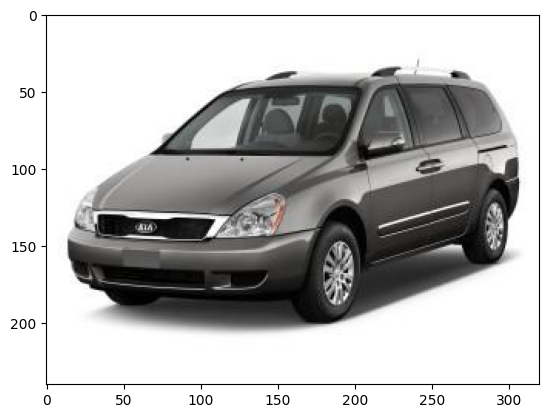

------- Output shape of Conv2d          -> torch.Size([1, 32, 240, 320]) -------
---------------- fraction of neurons firing: 0.5811620950698853 ----------------
-------- logits mean: 0.11951282620429993, logits std 1.02899169921875 ---------
--------------------------------------------------------------------------------
------- Output shape of BatchNorm2d     -> torch.Size([1, 32, 240, 320]) -------
---------------- fraction of neurons firing: 0.5279972553253174 ----------------
------- logits mean: 0.05567806214094162, logits std 1.0639019012451172 --------
--------------------------------------------------------------------------------
------- Output shape of ReLU            -> torch.Size([1, 32, 240, 320]) -------
---------------- fraction of neurons firing: 0.5279972553253174 ----------------
------- logits mean: 0.49738210439682007, logits std 0.5913816690444946 --------
--------------------------------------------------------------------------------
------- Output shape of Maxp

In [74]:
# Single forward pass example
with torch.no_grad():
    i = 0
    image, label = Xtest[i].load(), Ytest[i]
    plt.imshow(torch.Tensor.cpu(image.permute(1, 2, 0)))
    plt.show()
    logits, probs = forward(image.unsqueeze(0), training=False, verbose=True)
    print(f"Prediction {classes[probs[0].argmax()]}, confidence: {probs.max():2f}")
    print(f"GT: {classes[label.item()]}")

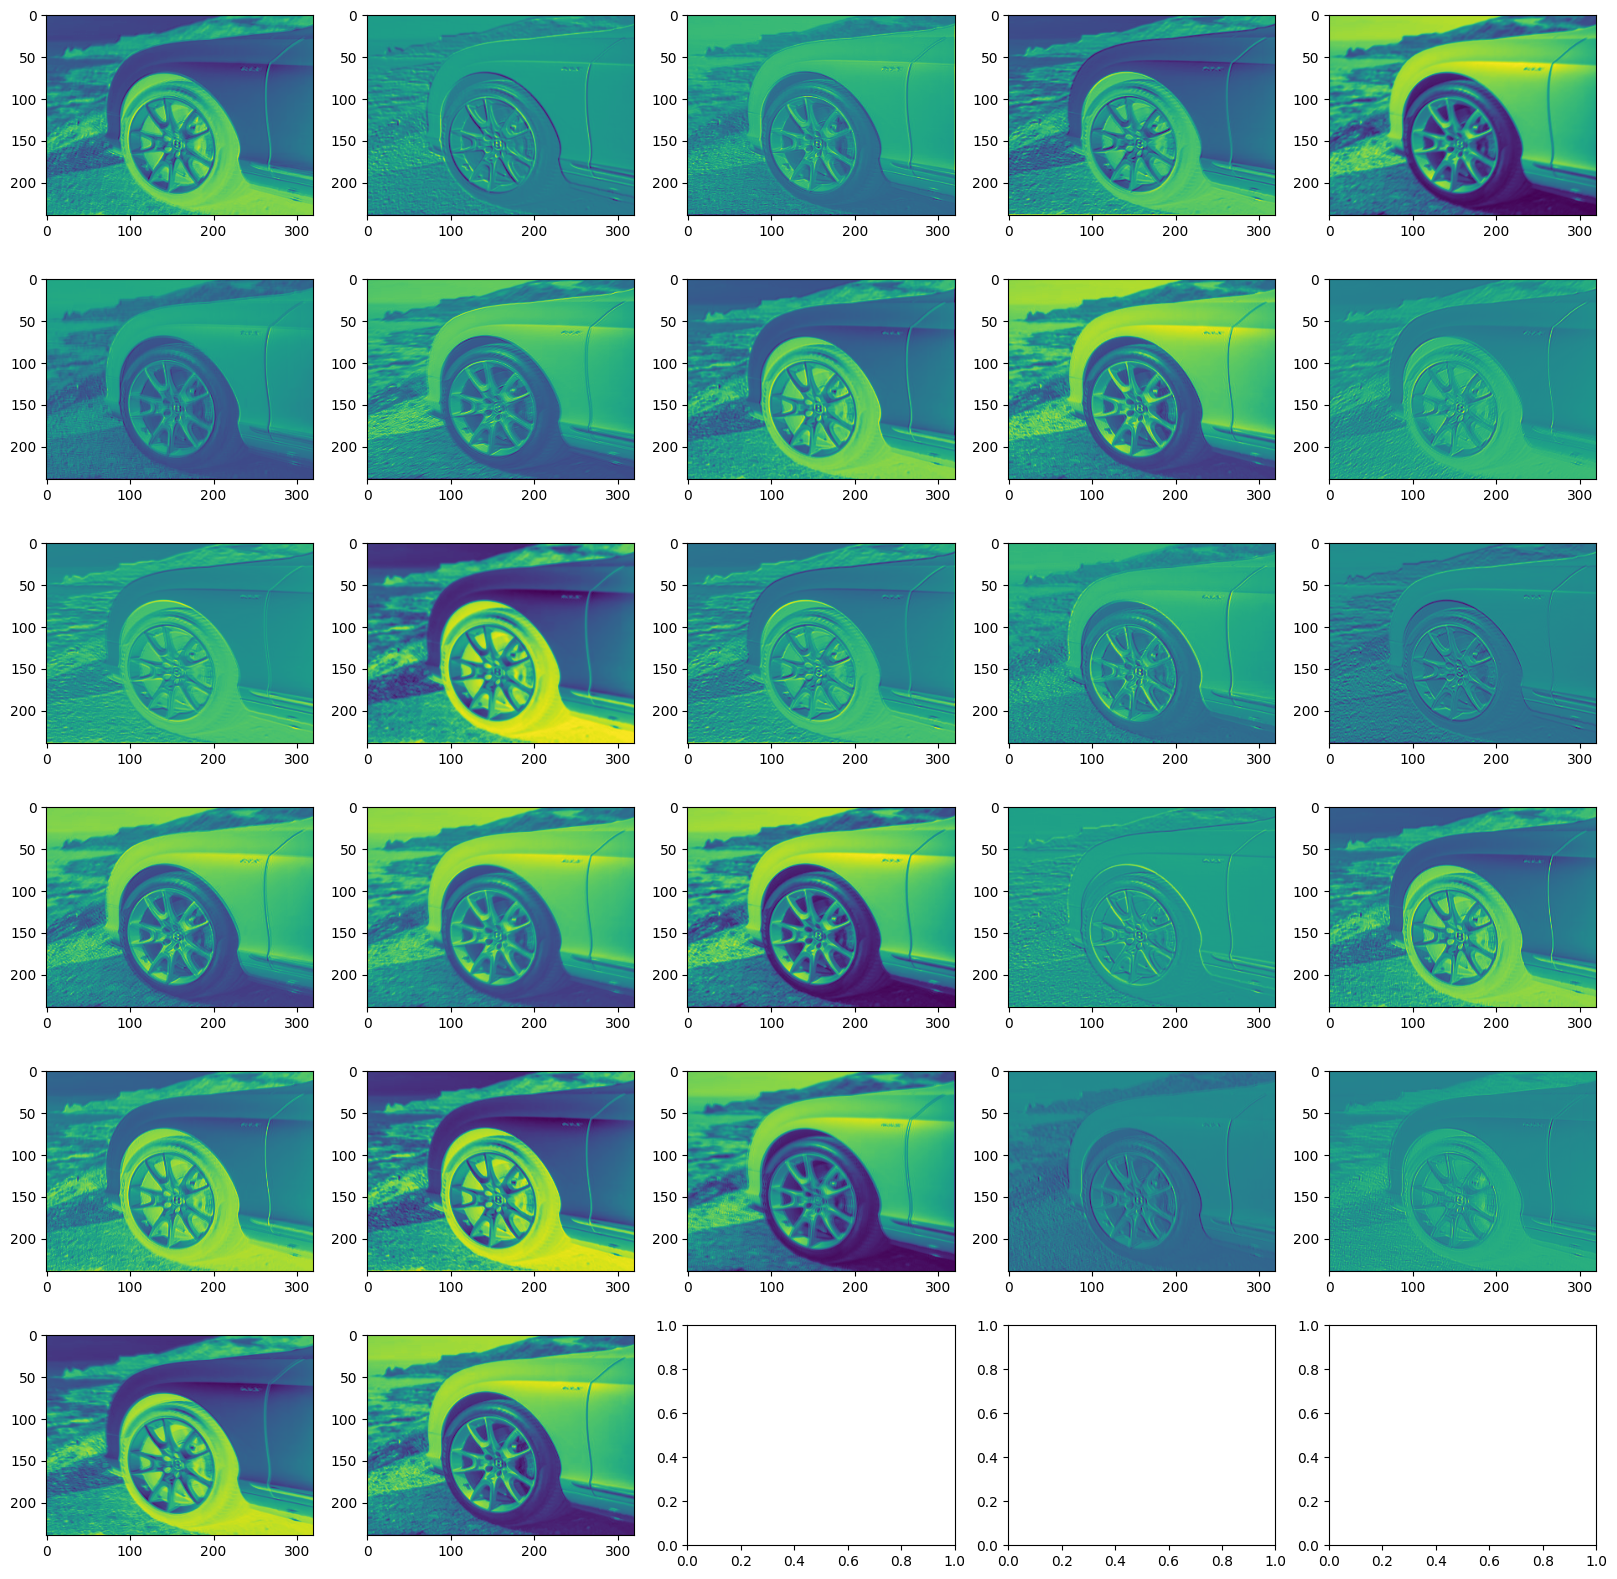

In [67]:
@torch.no_grad()
def plot_fmap_activations(layer: Conv2d, image: torch.Tensor):
    # forwward pass only for the layer
    featuremaps = layer(image.unsqueeze(0))
    # plot a colour map for each filter activation map
    cols = 5
    rows = layer.out_channels // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    for i, featuremap in enumerate(featuremaps[0]):
        axes[i // rows, i % 5].imshow(featuremap.cpu())

plot_fmap_activations(NET[0], Xtrain[0].load())

## Save the model

In [15]:
params = {}

for i, layer in enumerate(NET):
    cls_name = layer.__class__.__name__
    
    if isinstance(layer, Dense):
        params[f"{cls_name}_weights_{i}"] = layer.W
        params[f"{cls_name}_bias_{i}"] = layer.b
        
    elif isinstance(layer, Conv2d):
        params[f"{cls_name}_weights_{i}"] = layer.kernels
        params[f"{cls_name}_bias_{i}"] = layer.bias
        
    elif isinstance(layer, (BatchNorm, BatchNorm2d)):
        params[f"{cls_name}_gain_{i}"] = layer.gain
        params[f"{cls_name}_bias_{i}"] = layer.bias
        params[f"{cls_name}_running_mean_{i}"] = layer.running_mean
        params[f"{cls_name}_running_std_{i}"] = layer.running_std

torch.save(params, "car_brand_classifier2.pth")

for name, param in params.items():
    print(name, f"mean: {param.mean():.2f}, std: {param.std():.2f}")

Conv2d_weights_0 mean: -0.00, std: 0.27
Conv2d_bias_0 mean: 0.00, std: 0.00
BatchNorm2d_gain_1 mean: 1.00, std: 0.04
BatchNorm2d_bias_1 mean: 0.02, std: 0.03
BatchNorm2d_running_mean_1 mean: -0.01, std: 0.76
BatchNorm2d_running_std_1 mean: 0.40, std: 0.25
Conv2d_weights_4 mean: -0.00, std: 0.09
Conv2d_bias_4 mean: 0.00, std: 0.00
BatchNorm2d_gain_5 mean: 1.00, std: 0.02
BatchNorm2d_bias_5 mean: 0.01, std: 0.02
BatchNorm2d_running_mean_5 mean: -0.05, std: 0.57
BatchNorm2d_running_std_5 mean: 0.97, std: 0.06
Conv2d_weights_8 mean: -0.00, std: 0.06
Conv2d_bias_8 mean: 0.00, std: 0.00
BatchNorm2d_gain_9 mean: 1.00, std: 0.02
BatchNorm2d_bias_9 mean: -0.00, std: 0.01
BatchNorm2d_running_mean_9 mean: -0.09, std: 1.35
BatchNorm2d_running_std_9 mean: 1.07, std: 0.05
Conv2d_weights_12 mean: -0.00, std: 0.04
Conv2d_bias_12 mean: 0.00, std: 0.00
BatchNorm2d_gain_13 mean: 1.00, std: 0.01
BatchNorm2d_bias_13 mean: -0.01, std: 0.01
BatchNorm2d_running_mean_13 mean: -0.55, std: 1.10
BatchNorm2d_runni

## Load the model

In [11]:
Conv2d.reset(); Dense.reset(); BatchNorm.reset(); BatchNorm2d.reset()
loaded_params = torch.load('car_brand_classifier.pth', map_location=device)
for name, param in loaded_params.items():
    index = int(name.split("_")[-1])
    layer = NET[index]
    print("Loading layer", layer.__class__.__name__, name, param.shape, f"mean: {param.mean():.2f}, std: {param.std():.2f}")
    param.requires_grad = True
    if isinstance(layer, Dense):
        Dense.params.append(param)
        if "weights" in name:
            layer.W = param
        else:
            layer.b = param
        
    elif isinstance(layer, Conv2d):
        Conv2d.params.append(param)
        if "weights" in name:
            layer.kernels = param
        else:
            layer.bias = param
        
    elif isinstance(layer, (BatchNorm, BatchNorm2d)):
        if "gain" in name:
            layer.gain = param
        elif "bias" in name:
            layer.bias = param
        elif "running_mean" in name:
            layer.running_mean = param
        else:
            layer.running_std = param
        

Loading layer Conv2d Conv2d_weights_0 torch.Size([32, 3, 3, 3]) mean: -0.00, std: 0.27
Loading layer Conv2d Conv2d_bias_0 torch.Size([32]) mean: 0.00, std: 0.00
Loading layer BatchNorm2d BatchNorm2d_gain_1 torch.Size([1, 32, 1, 1]) mean: 1.00, std: 0.04
Loading layer BatchNorm2d BatchNorm2d_bias_1 torch.Size([1, 32, 1, 1]) mean: 0.02, std: 0.03
Loading layer BatchNorm2d BatchNorm2d_running_mean_1 torch.Size([1, 32, 1, 1]) mean: -0.01, std: 0.76
Loading layer BatchNorm2d BatchNorm2d_running_std_1 torch.Size([1, 32, 1, 1]) mean: 0.40, std: 0.25
Loading layer Conv2d Conv2d_weights_4 torch.Size([64, 32, 3, 3]) mean: -0.00, std: 0.09
Loading layer Conv2d Conv2d_bias_4 torch.Size([64]) mean: 0.00, std: 0.00
Loading layer BatchNorm2d BatchNorm2d_gain_5 torch.Size([1, 64, 1, 1]) mean: 1.00, std: 0.02
Loading layer BatchNorm2d BatchNorm2d_bias_5 torch.Size([1, 64, 1, 1]) mean: 0.01, std: 0.02
Loading layer BatchNorm2d BatchNorm2d_running_mean_5 torch.Size([1, 64, 1, 1]) mean: -0.05, std: 0.57
L

## Plot some predictions

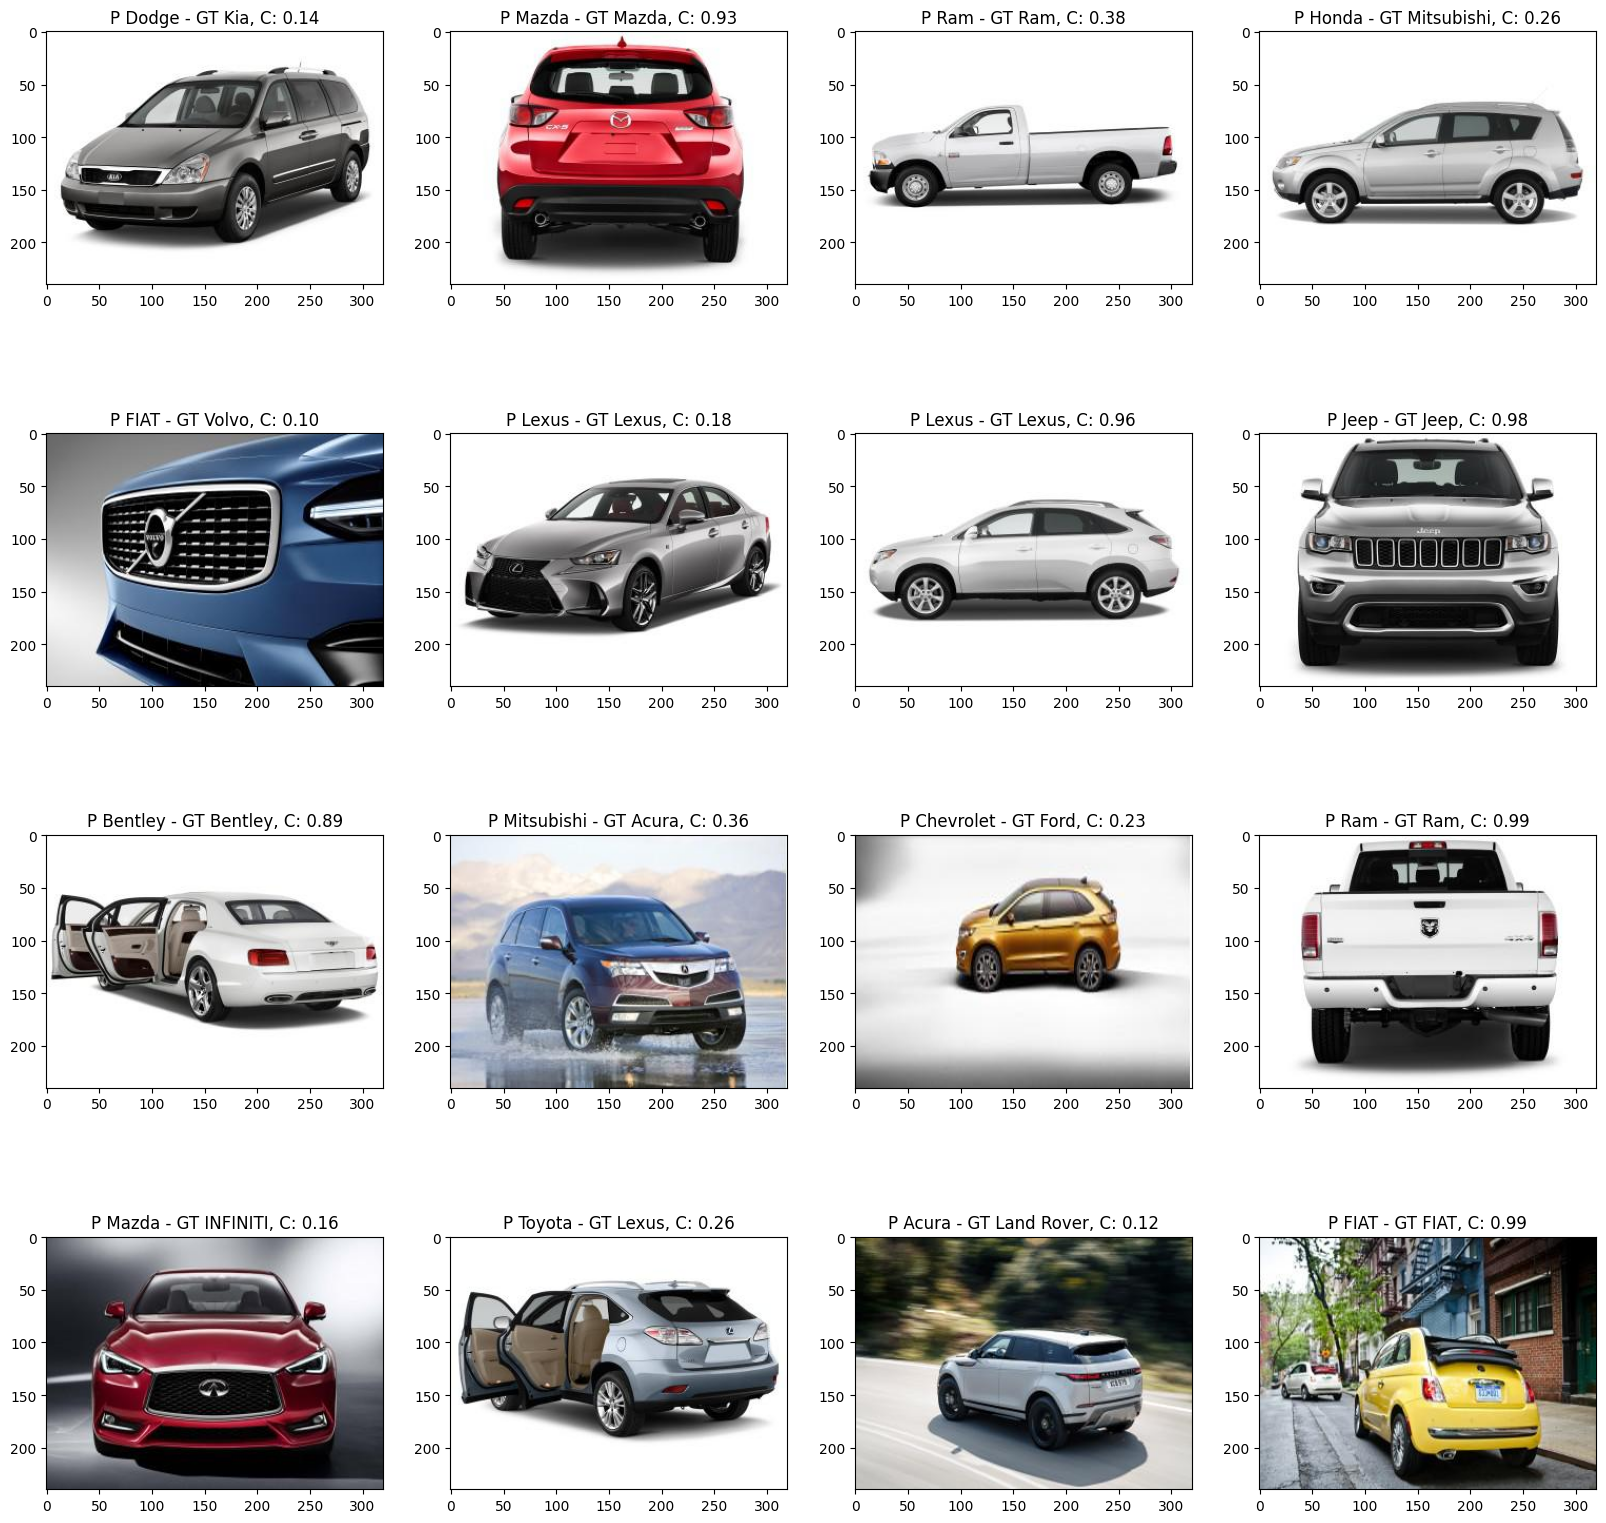

In [87]:
@torch.no_grad()
def plot_predictions(rows: int, cols: int):
    X = torch.stack([img.load() for img in Xtest[:rows*cols]])
    Y = Ytest[:rows*cols]
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    for i in range(rows):
        for j in range(cols):
            axes[i, j].imshow(X[i*rows + j].permute(1, 2, 0).cpu())
            _, probs = forward(X, training=False)
            axes[i, j].set_title(f"P {classes[probs[i*rows + j].argmax()]} - GT {classes[Y[i*rows + j]]}, C: {probs[i*rows + j].max():.2f}")

plot_predictions(4, 4)

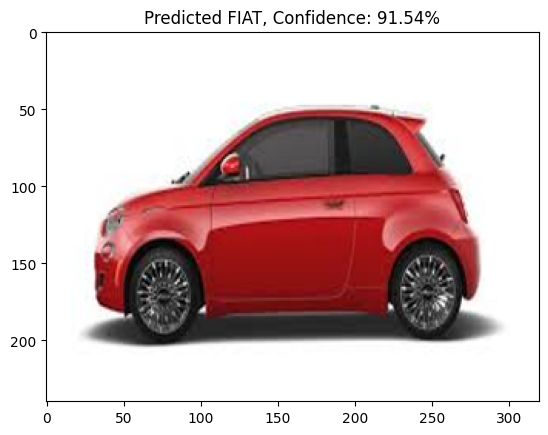

In [86]:
@torch.no_grad()
def plot_custom(image_path):
    X = torch.tensor(LazyImage(image_path).load()).unsqueeze(0)
    _, probs = forward(X, training=False)
    plt.imshow(X[0].permute(1, 2, 0).cpu())
    plt.title(f"Predicted {classes[probs[0].argmax()]}, Confidence: {probs[0].max():.2%}")
plot_custom("images.jpg")